# Import

In [1]:
import sys

#TODO: 相対パス
root_dir = '/Users/taichi/Library/CloudStorage/OneDrive-個人用/Documents/project/lab/bachelor/cml_pytorch2'
if root_dir not in sys.path:
    sys.path.append('/Users/taichi/Library/CloudStorage/OneDrive-個人用/Documents/project/lab/bachelor/cml_pytorch2')

import torch
from torch import nn, optim
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from modules import losses, models, samplers, regularizers, evaluators, trainers, datasets, distributions

# DataSet

In [2]:
dataset = datasets.ML100k()
n_user = dataset.n_user
n_item = dataset.n_item
train_set, test_set = dataset.implicit_feedback_data(tail_threshold=20)

# device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.LongTensor(test_set).to(device)

# Evaluator

In [3]:
# k
ks = [50]

# Accuracy
score_function_dict = {
    # "nDCG" : evaluators.ndcg,
    # "MAP" : evaluators.average_precision,
    "Recall": evaluators.recall
}
accuracy_evaluator = evaluators.AccuracyEvaluator(test_set, score_function_dict, ks)

# Unpopularity
unpopularity_evaluator = evaluators.UnpopularityEvaluator(test_set, ks)

# Hubness
hubness_evaluator = evaluators.HubnessEvaluator(test_set, ks)

# Sampler

In [4]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [5]:
# Hyperparameters
lr = 1e-3
n_batch = 256
n_epoch = 30
valid_per_epoch = 10
n_item_sample = 30
n_user_sample = 30
n_dims = [20, 40, 60, 80, 100]

def evaluate_result(evaluator):
    re = []
    for n_dim in n_dims:
        model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = losses.SumTripletLoss(margin=1).to(device)
        trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler)
        trainer.fit(n_batch, n_epoch, evaluator, valid_per_epoch)
        re.append(trainer.valid_scores.iloc[-1, 0])
    
    return re

# Accuracy

100%|████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:14<00:00, 66.62it/s]


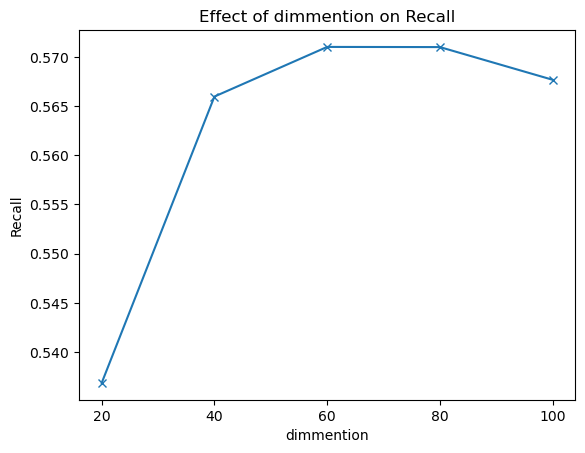

In [6]:
plt.plot(n_dims, evaluate_result(accuracy_evaluator), marker='x')
plt.title('Effect of dimmention on Recall')
plt.xlabel('dimmention')
plt.ylabel('Recall')
plt.xticks(n_dims)
plt.show()

# Unpopularity

100%|████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:12<00:00, 73.02it/s]


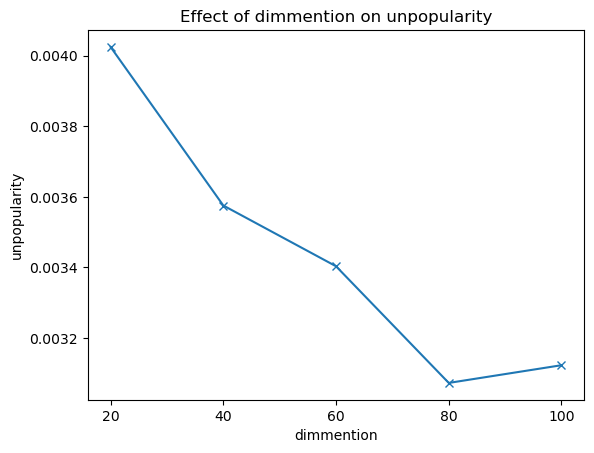

In [7]:
plt.plot(n_dims, evaluate_result(unpopularity_evaluator), marker='x')
plt.title('Effect of dimmention on unpopularity')
plt.xlabel('dimmention')
plt.ylabel('unpopularity')
plt.xticks(n_dims)
plt.show()

# Hubness

100%|███████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:06<00:00, 150.68it/s]


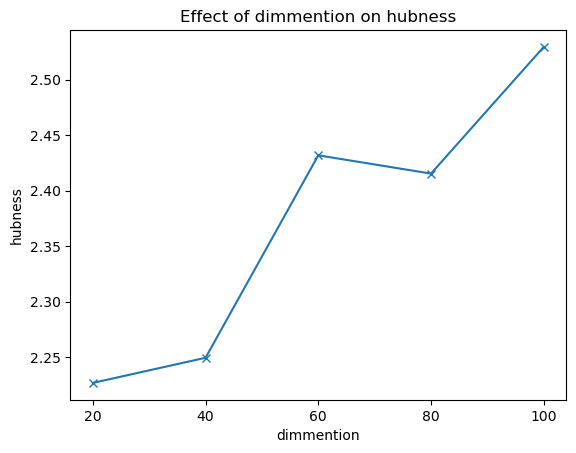

In [8]:
plt.plot(n_dims, evaluate_result(hubness_evaluator), marker='x')
plt.title('Effect of dimmention on hubness')
plt.xlabel('dimmention')
plt.ylabel('hubness')
plt.xticks(n_dims)
plt.show()